# Understanding and Contrasting Multilayer Perceptrons and Convolutional Neural Networks for Image Classification
**Owner :** Ling-Yun, Huang

In [1]:
### import libraries

## torch
# for image dataset loaded
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# for networks training
import torch.nn as nn
import torch.optim as optim
import time

## print the images
import matplotlib.pyplot as plt
import random

## for model evaluation
from sklearn import metrics

### Data loaded, image transformation, and dataset split

The code for image data preprocessing and model training were adopted from the [PyTorch library tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [2]:
# Define image data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize
    transforms.ToTensor(),  # to tensor
])

# The paths of datasets
train_dir = 'Intel Image Classification/seg_train/seg_train'
test_dir = 'Intel Image Classification/seg_test/seg_test'

# Load datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
unseen_dataset = datasets.ImageFolder(test_dir, transform=transform) # this dataset will remain unseen until model been trained

class_names = train_dataset.classes

# Print the class names and sample sizes
print('The classes are:', class_names)
print('')
print('The length of train_dataset:', len(train_dataset))
print('The length of unseen_dataset:', len(unseen_dataset))

The classes are: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

The length of train_dataset: 14034
The length of unseen_dataset: 3000


#### Print out the images for each class

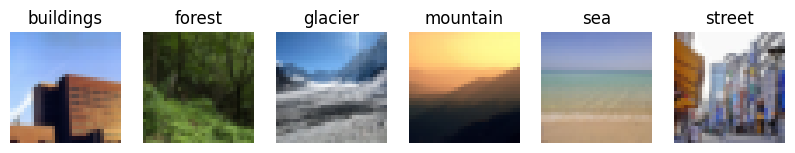

In [3]:
# Find one image per class
one_image_per_class = {} # store one image for each class
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    class_name = class_names[label]
    if class_name not in one_image_per_class:
        one_image_per_class[class_name] = image
        if len(one_image_per_class) == len(class_names):
            break 

# Plot images with class names
fig, axes = plt.subplots(1, len(class_names), figsize=(10, 3))
for i, (class_name, image) in enumerate(one_image_per_class.items()):
    img = image.permute(1, 2, 0) # Convert from tensor to numpy array
    axes[i].imshow(img)  
    axes[i].set_title(class_name)
    axes[i].axis('off')
plt.show()

#### Split the train dataset into training, validation, testing sets.

In [ ]:
# Define the percentage in splitting with 80/10/10
train_size = int(0.8 * len(train_dataset)) # 80% for training the model
val_size = int(0.1 * len(train_dataset)) # 10% for validation to monitor while training to avoid overfitting
test_size = len(train_dataset) - train_size - val_size # Remaining 10% for evaluate the model's performance

torch.manual_seed(427) # set the random seed
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# print the size of each size
print("The sizes of train, validate, and test sets:", len(train_set), ",", len(val_set), ",", len(test_set))

#### Create DataLoaders for later neural networks training.

In [ ]:
# Define batch size for DataLoader
batch_size = 32

# Create DataLoader for training, validation, testing, and unseen datasets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
unseen_loader = DataLoader(unseen_dataset, batch_size=batch_size, shuffle=False)

### Neural Networks Training and Testing

Two methods will use following function to train the model

In [3]:
def Model_train_test(model, learning_rate):
    torch.manual_seed(427) # set the random seed
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training process
    num_epochs = 20 # define max epochs
    best_val_loss = float('inf') # monitor the model's val loss
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    
    start_time = time.time() # Start timer
    for epoch in range(num_epochs):
        model.train()  # model training
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval() # monitor model perform on validation set
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                val_outputs = model(inputs)
                val_loss += criterion(val_outputs, labels).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= 5 and epoch+1 < num_epochs: # setting early stop if the loss of val not improve in 5 epochs
                print(f"Early stop!, Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
                break
    
    if epoch+1 == num_epochs:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    end_time = time.time() # Stop timer
    training_time = end_time - start_time # Calculate training time
    
    # Evaluate the model on testing set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on testing set: {100 * correct / total}%, Training time: {training_time}")
    print('')
    
    return train_losses, val_losses

#### MLPs training in image classification task

In [7]:
# The architecture of MLPs with one hidden layers
class MLP_1(nn.Module):
    def __init__(self, hidden_size):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(3*32*32, hidden_size) # image size with 3 channels
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 6) # 6 classes
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # reshaping multi-dimensional data into a one-dimensional vector
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

In [8]:
# The architecture of MLPs with two hidden layers
class MLP_2(nn.Module):
    def __init__(self, hidden_size):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(3*32*32, hidden_size) # image size with 3 channels
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 6) # 6 classes
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # reshaping multi-dimensional data into a one-dimensional vector
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

In [9]:
# Setting hidden size and learning rate with one hidden layer
MLP_1_64_0001 = MLP_1(64)
print(f'Training 1 hidden layer MLP with 64 neurones and learning rate 0.0001')
trainloss_1_64_0001, valloss_1_64_0001 = Model_train_test(MLP_1_64_0001, 0.0001)

MLP_1_128_0001 = MLP_1(128)
print(f'Training 1 hidden layer MLP with 128 neurones and learning rate 0.0001')
trainloss_1_128_0001, valloss_1_128_0001 = Model_train_test(MLP_1_128_0001, 0.0001)

MLP_1_256_0001 = MLP_1(256)
print(f'Training 1 hidden layer MLP with 256 neurones and learning rate 0.0001')
trainloss_1_256_0001, valloss_1_256_0001 = Model_train_test(MLP_1_256_0001, 0.0001)

MLP_1_64_001 = MLP_1(64)
print(f'Training 1 hidden layer MLP with 64 neurones and learning rate 0.001')
trainloss_1_64_001, valloss_1_64_001 = Model_train_test(MLP_1_64_001, 0.001)

MLP_1_128_001 = MLP_1(128)
print(f'Training 1 hidden layer MLP with 128 neurones and learning rate 0.001')
trainloss_1_128_001, valloss_1_128_001 = Model_train_test(MLP_1_128_001, 0.001)

MLP_1_256_001 = MLP_1(256)
print(f'Training 1 hidden layer MLP with 256 neurones and learning rate 0.001')
trainloss_1_256_001, valloss_1_256_001 = Model_train_test(MLP_1_256_001, 0.001)

MLP_1_64_01 = MLP_1(64)
print(f'Training 1 hidden layer MLP with 64 neurones and learning rate 0.01')
trainloss_1_64_01, valloss_1_64_01 = Model_train_test(MLP_1_64_01, 0.01)

MLP_1_128_01 = MLP_1(128)
print(f'Training 1 hidden layer MLP with 128 neurones and learning rate 0.01')
trainloss_1_128_01, valloss_1_128_01 = Model_train_test(MLP_1_128_01, 0.01)

MLP_1_256_01 = MLP_1(256)
print(f'Training 1 hidden layer MLP with 256 neurones and learning rate 0.01')
trainloss_1_256_01, valloss_1_256_01 = Model_train_test(MLP_1_256_01, 0.01)

Training 1 hidden layer MLP with 64 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.5296571590961554, Validation Loss: 1.5272133133628152
Accuracy on testing set: 53.63247863247863%, Training time: 132.7697992324829

Training 1 hidden layer MLP with 128 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.46901073449018, Validation Loss: 1.4850292856043035
Accuracy on testing set: 58.04843304843305%, Training time: 133.40239787101746

Training 1 hidden layer MLP with 256 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.459829978793435, Validation Loss: 1.4814661795442754
Accuracy on testing set: 57.83475783475784%, Training time: 140.617169380188

Training 1 hidden layer MLP with 64 neurones and learning rate 0.001
Epoch 20, Training Loss: 1.4519430201957029, Validation Loss: 1.4811902073296634
Accuracy on testing set: 59.686609686609685%, Training time: 128.0481879711151

Training 1 hidden layer MLP with 128 neurones and learning rate 0.001
Epoch 20, T

In [11]:
# Setting hidden size and learning rate with two hidden layers
MLP_2_64_0001 = MLP_2(64)
print(f'Training 2 hidden layers MLP with 64 neurones and learning rate 0.0001')
trainloss_2_64_0001, valloss_2_64_0001 = Model_train_test(MLP_2_64_0001, 0.0001)

MLP_2_128_0001 = MLP_2(128)
print(f'Training 2 hidden layers MLP with 128 neurones and learning rate 0.0001')
trainloss_2_128_0001, valloss_2_128_0001 = Model_train_test(MLP_2_128_0001, 0.0001)

MLP_2_256_0001 = MLP_2(256)
print(f'Training 2 hidden layers MLP with 256 neurones and learning rate 0.0001')
trainloss_2_256_0001, valloss_2_256_0001 = Model_train_test(MLP_2_256_0001, 0.0001)

MLP_2_64_001 = MLP_2(64)
print(f'Training 2 hidden layers MLP with 64 neurones and learning rate 0.001')
trainloss_2_64_001, valloss_2_64_001 = Model_train_test(MLP_2_64_001, 0.001)

MLP_2_128_001 = MLP_2(128)
print(f'Training 2 hidden layers MLP with 128 neurones and learning rate 0.001')
trainloss_2_128_001, valloss_2_128_001 = Model_train_test(MLP_2_128_001, 0.001)

MLP_2_256_001 = MLP_2(256)
print(f'Training 2 hidden layers MLP with 256 neurones and learning rate 0.001')
trainloss_2_256_001, valloss_2_256_001 = Model_train_test(MLP_2_256_001, 0.001)

MLP_2_64_01 = MLP_2(64)
print(f'Training 2 hidden layers MLP with 64 neurones and learning rate 0.01')
trainloss_2_64_01, valloss_2_64_01 = Model_train_test(MLP_2_64_01, 0.01)

MLP_2_128_01 = MLP_2(128)
print(f'Training 2 hidden layers MLP with 128 neurones and learning rate 0.01')
trainloss_2_128_01, valloss_2_128_01 = Model_train_test(MLP_2_128_01, 0.01)

MLP_2_256_01 = MLP_2(256)
print(f'Training 2 hidden layers MLP with 256 neurones and learning rate 0.01')
trainloss_2_256_01, valloss_2_256_01 = Model_train_test(MLP_2_256_01, 0.01)

Training 2 hidden layers MLP with 64 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.4673807002879955, Validation Loss: 1.4817046252163975
Accuracy on testing set: 57.9059829059829%, Training time: 131.77923703193665

Training 2 hidden layers MLP with 128 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.4541163149043026, Validation Loss: 1.4754022847522388
Accuracy on testing set: 58.76068376068376%, Training time: 137.48002886772156

Training 2 hidden layers MLP with 256 neurones and learning rate 0.0001
Epoch 20, Training Loss: 1.4410297476667964, Validation Loss: 1.4623507992787794
Accuracy on testing set: 59.116809116809115%, Training time: 147.89099216461182

Training 2 hidden layers MLP with 64 neurones and learning rate 0.001
Early stop!, Epoch 14, Training Loss: 1.4560572279144897, Validation Loss: 1.5115362243218855
Accuracy on testing set: 56.12535612535613%, Training time: 90.70372724533081

Training 2 hidden layers MLP with 128 neurones and learning

#### CNNs training in image classification task

In [12]:
# Define CNN architecture with one conventional layer
class CNN(nn.Module):
    def __init__(self, kernel_size, hidden_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, 
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(hidden_size * 16 * 16, 64)  # Adjusted for image input size
        self.fc2 = nn.Linear(64, 6)  # 6 classes for output

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
# Setting kernel size, filters, and learning rate 0.0001
CNN_3_10_0001 = CNN(3, 10)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.0001')
trainloss_3_10_0001, valloss_3_10_0001 = Model_train_test(CNN_3_10_0001, 0.0001)

CNN_3_20_0001 = CNN(3, 20)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.0001')
trainloss_3_20_0001, valloss_3_20_0001 = Model_train_test(CNN_3_20_0001, 0.0001)

CNN_5_10_0001 = CNN(5, 10)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.0001')
trainloss_5_10_0001, valloss_5_10_0001 = Model_train_test(CNN_5_10_0001, 0.0001)

CNN_5_20_0001 = CNN(5, 20)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.0001')
trainloss_5_20_0001, valloss_5_20_0001 = Model_train_test(CNN_5_20_0001, 0.0001)

CNN_7_10_0001 = CNN(7, 10)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 10 filters, and learning rate 0.0001')
trainloss_7_10_0001, valloss_7_10_0001 = Model_train_test(CNN_7_10_0001, 0.0001)

CNN_7_20_0001 = CNN(7, 20)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 20 filters, and learning rate 0.0001')
trainloss_7_20_0001, valloss_7_20_0001 = Model_train_test(CNN_7_20_0001, 0.0001)

Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.0001
Epoch 20, Training Loss: 0.936140525035369, Validation Loss: 0.9266347776759755
Accuracy on testing set: 63.46153846153846%, Training time: 225.7922990322113

Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.0001
Epoch 20, Training Loss: 0.8056770054533271, Validation Loss: 0.8442774956876581
Accuracy on testing set: 70.94017094017094%, Training time: 326.67026114463806

Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.0001
Epoch 20, Training Loss: 0.8674635609500428, Validation Loss: 0.8894028189507398
Accuracy on testing set: 68.94586894586895%, Training time: 251.85704708099365

Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.0001
Epoch 20, Training Loss: 0.7712550841675185, Validation Loss: 0.8149087855761702
Accuracy on testing set: 70.58404558404558%, Train

In [14]:
# Setting kernel size, filters, and learning rate 0.001
CNN_3_10_001 = CNN(3, 10)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.001')
trainloss_3_10_001, valloss_3_10_001 = Model_train_test(CNN_3_10_001, 0.001)

CNN_3_20_001 = CNN(3, 20)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.001')
trainloss_3_20_001, valloss_3_20_001 = Model_train_test(CNN_3_20_001, 0.001)

CNN_5_10_001 = CNN(5, 10)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.001')
trainloss_5_10_001, valloss_5_10_001 = Model_train_test(CNN_5_10_001, 0.001)

CNN_5_20_001 = CNN(5, 20)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.001')
trainloss_5_20_001, valloss_5_20_001 = Model_train_test(CNN_5_20_001, 0.001)

CNN_7_10_001 = CNN(7, 10)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 10 filters, and learning rate 0.001')
trainloss_7_10_001, valloss_7_10_001 = Model_train_test(CNN_7_10_001, 0.001)

CNN_7_20_001 = CNN(7, 20)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 20 filters, and learning rate 0.001')
trainloss_7_20_001, valloss_7_20_001 = Model_train_test(CNN_7_20_001, 0.001)

Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.001
Early stop!, Epoch 12, Training Loss: 0.5584611561138746, Validation Loss: 0.790974307466637
Accuracy on testing set: 72.29344729344729%, Training time: 132.64963221549988

Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.001
Early stop!, Epoch 15, Training Loss: 0.44473381820227686, Validation Loss: 0.7778010679916902
Accuracy on testing set: 73.21937321937322%, Training time: 218.369726896286

Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.001
Early stop!, Epoch 13, Training Loss: 0.5960439138772481, Validation Loss: 0.8016969256780364
Accuracy on testing set: 73.71794871794872%, Training time: 153.30926394462585

Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.001
Early stop!, Epoch 15, Training Loss: 0.3964740506179652, Validation Loss: 0.8489885174415328
Ac

In [16]:
# Setting kernel size, filters, and learning rate 0.01
CNN_3_10_01 = CNN(3, 10)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.01')
trainloss_3_10_01, valloss_3_10_01 = Model_train_test(CNN_3_10_01, 0.01)

CNN_3_20_01 = CNN(3, 20)
print(f'Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.01')
trainloss_3_20_01, valloss_3_20_01 = Model_train_test(CNN_3_20_01, 0.01)

CNN_5_10_01 = CNN(5, 10)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.01')
trainloss_5_10_01, valloss_5_10_01 = Model_train_test(CNN_5_10_01, 0.01)

CNN_5_20_01 = CNN(5, 20)
print(f'Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.01')
trainloss_5_20_01, valloss_5_20_01 = Model_train_test(CNN_5_20_01, 0.01)

CNN_7_10_01 = CNN(7, 10)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 10 filters, and learning rate 0.01')
trainloss_7_10_01, valloss_7_10_01 = Model_train_test(CNN_7_10_01, 0.01)

CNN_7_20_01 = CNN(7, 20)
print(f'Training 1 conventional layer in CNNs with 7x7 kernel size, 20 filters, and learning rate 0.01')
trainloss_7_20_01, valloss_7_20_01 = Model_train_test(CNN_7_20_01, 0.01)

Training 1 conventional layer in CNNs with 3x3 kernel size, 10 filters, and learning rate 0.01
Early stop!, Epoch 8, Training Loss: 0.6738325641026185, Validation Loss: 1.0738822709430347
Accuracy on testing set: 65.5982905982906%, Training time: 91.09913301467896

Training 1 conventional layer in CNNs with 3x3 kernel size, 20 filters, and learning rate 0.01
Early stop!, Epoch 9, Training Loss: 0.7098736943852189, Validation Loss: 1.1018585684624584
Accuracy on testing set: 64.67236467236468%, Training time: 132.3381769657135

Training 1 conventional layer in CNNs with 5x5 kernel size, 10 filters, and learning rate 0.01
Early stop!, Epoch 9, Training Loss: 0.7866328033456775, Validation Loss: 1.1518876132639972
Accuracy on testing set: 61.53846153846154%, Training time: 108.55662608146667

Training 1 conventional layer in CNNs with 5x5 kernel size, 20 filters, and learning rate 0.01
Early stop!, Epoch 13, Training Loss: 0.8616339984612588, Validation Loss: 1.2228981540961699
Accuracy o

### Store Two Best Models
1. In MLPs, the best model is with one hidden layers [64], and learning rate is 0.001.
2. In CNNs, the best model is with one conventional layers kernel size = 5, filters = 10, and learning rate = 0.001.

In [51]:
# Store the best model in MLPs
MLP_best = MLP_1_64_001
MLP_train_losses, MLP_val_losses = trainloss_1_64_001, valloss_1_64_001
torch.save(MLP_best, 'MLP_best.pth')

# Store the best model in CNNs
CNN_best = CNN_5_10_001
CNN_train_losses, CNN_val_losses = trainloss_5_10_001, valloss_5_10_001
torch.save(CNN_best, 'CNN_best.pth')

### Test two best models with unseen dataset

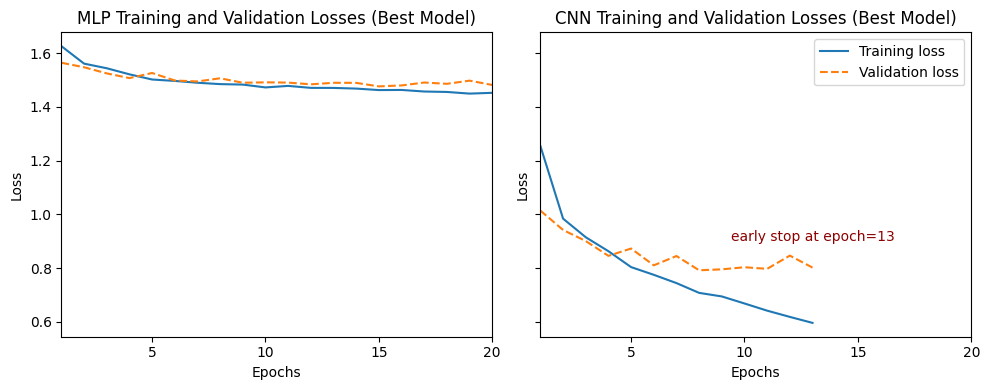

In [55]:
# Plotting MLP and CNN training and validation losses for the best models
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plotting MLP
epochs = range(1, len(MLP_train_losses) + 1)
axes[0].plot(epochs, MLP_train_losses, label='Training loss')
axes[0].plot(epochs, MLP_val_losses, label='Validation loss', linestyle='dashed')

axes[0].set_title('MLP Training and Validation Losses (Best Model)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
#axes[0].legend()
axes[0].set_xticks([5, 10, 15, 20])
axes[0].set_xlim(1, 20)  # Set x-axis limit to 20 epochs
#axes[0].set_ylim(0.6, 2)

# Plotting CNN 
epochs = range(1, len(CNN_train_losses) + 1)
axes[1].plot(epochs, CNN_train_losses, label='Training loss')
axes[1].plot(epochs, CNN_val_losses, label='Validation loss', linestyle='dashed')

axes[1].set_title('CNN Training and Validation Losses (Best Model)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_xticks([5, 10, 15, 20])
axes[1].set_xlim(1, 20)  # Set x-axis limit to 20 epochs
axes[1].text(13, 0.9, 'early stop at epoch=13', fontsize=10, color='darkred', ha='center')

plt.tight_layout()
plt.show()

In [48]:
# Function of Model performance
def Model_performance(model, loader):

    torch.manual_seed(427) # set the random seed
    model.eval()  # Set the model to evaluation mode
    
    # store true labels and predicted labels
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Convert tensors to numpy arrays and append to lists
            true_labels.extend(labels.numpy())
            pred_labels.extend(predicted.numpy())

    return true_labels, pred_labels

# Plot random images with true and predict labels
def random_images_plot(true_labels, pred_labels, loader):

    # random indices from the loader dataset
    random_indices = random.sample(range(len(loader.dataset)), 12)

    # Extract images and their true and predicted labels
    random_images = [loader.dataset[i][0] for i in random_indices]
    random_true_labels = [true_labels[i] for i in random_indices]
    random_pred_labels = [pred_labels[i] for i in random_indices]

    # Plot images
    plt.figure(figsize=(10, 5))
    for i in range(12):
        plt.subplot(2, 6, i + 1)
        plt.imshow(random_images[i].permute(1, 2, 0))  # Convert tensor to image
        plt.title(f'True: {random_true_labels[i]}\nPredicted: {random_pred_labels[i]}')
        plt.axis('off')
    plt.show()

Accuracy: 0.5546666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.32      0.38       437
           1       0.80      0.71      0.75       474
           2       0.49      0.72      0.58       553
           3       0.58      0.61      0.60       525
           4       0.42      0.24      0.31       510
           5       0.55      0.69      0.61       501

    accuracy                           0.55      3000
   macro avg       0.55      0.55      0.54      3000
weighted avg       0.55      0.55      0.54      3000



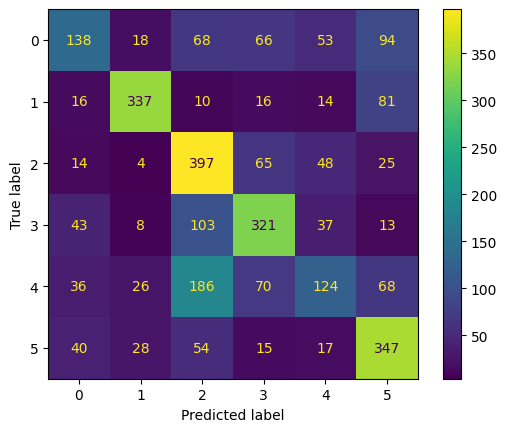

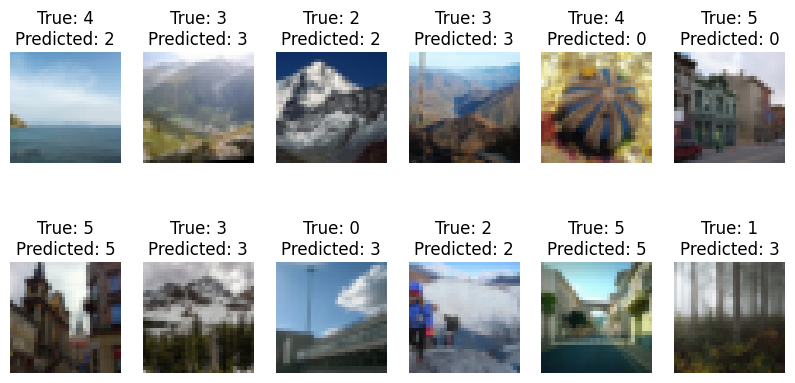

In [52]:
MLP_best = torch.load('MLP_best.pth')
true_labels, pred_labels = Model_performance(MLP_best, unseen_loader)

# Evaluate performance
accuracy = metrics.accuracy_score(true_labels, pred_labels)
report = metrics.classification_report(true_labels, pred_labels)

# print results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
metrics.ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels)
plt.show()

random_images_plot(true_labels, pred_labels, unseen_loader)

In [53]:
MLP_best

MLP_1(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

Accuracy: 0.7056666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.60      0.64       437
           1       0.94      0.74      0.83       474
           2       0.70      0.71      0.71       553
           3       0.65      0.70      0.67       525
           4       0.68      0.63      0.65       510
           5       0.66      0.85      0.74       501

    accuracy                           0.71      3000
   macro avg       0.72      0.70      0.71      3000
weighted avg       0.72      0.71      0.71      3000



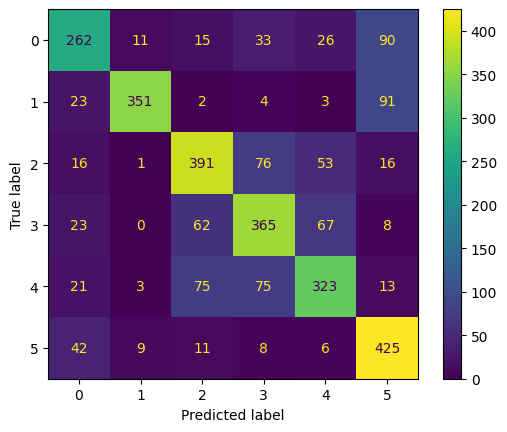

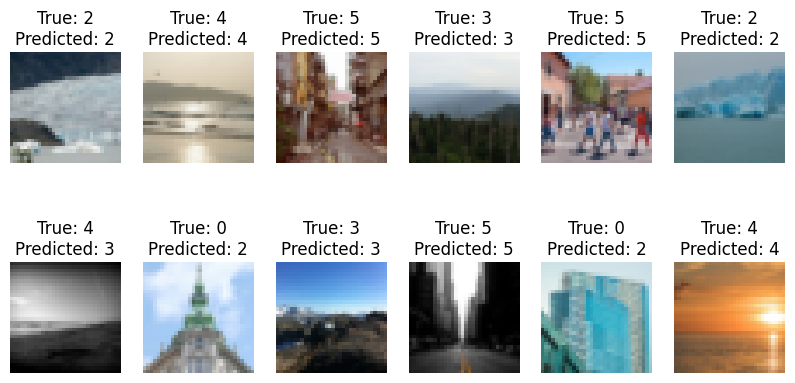

In [54]:
CNN_best = torch.load('CNN_best.pth')
true_labels, pred_labels = Model_performance(CNN_best, unseen_loader)

# Evaluate performance
accuracy = metrics.accuracy_score(true_labels, pred_labels)
report = metrics.classification_report(true_labels, pred_labels)

# print results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
metrics.ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels)
plt.show()

random_images_plot(true_labels, pred_labels, unseen_loader)

In [56]:
CNN_best

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2560, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

## All model trained loss plot

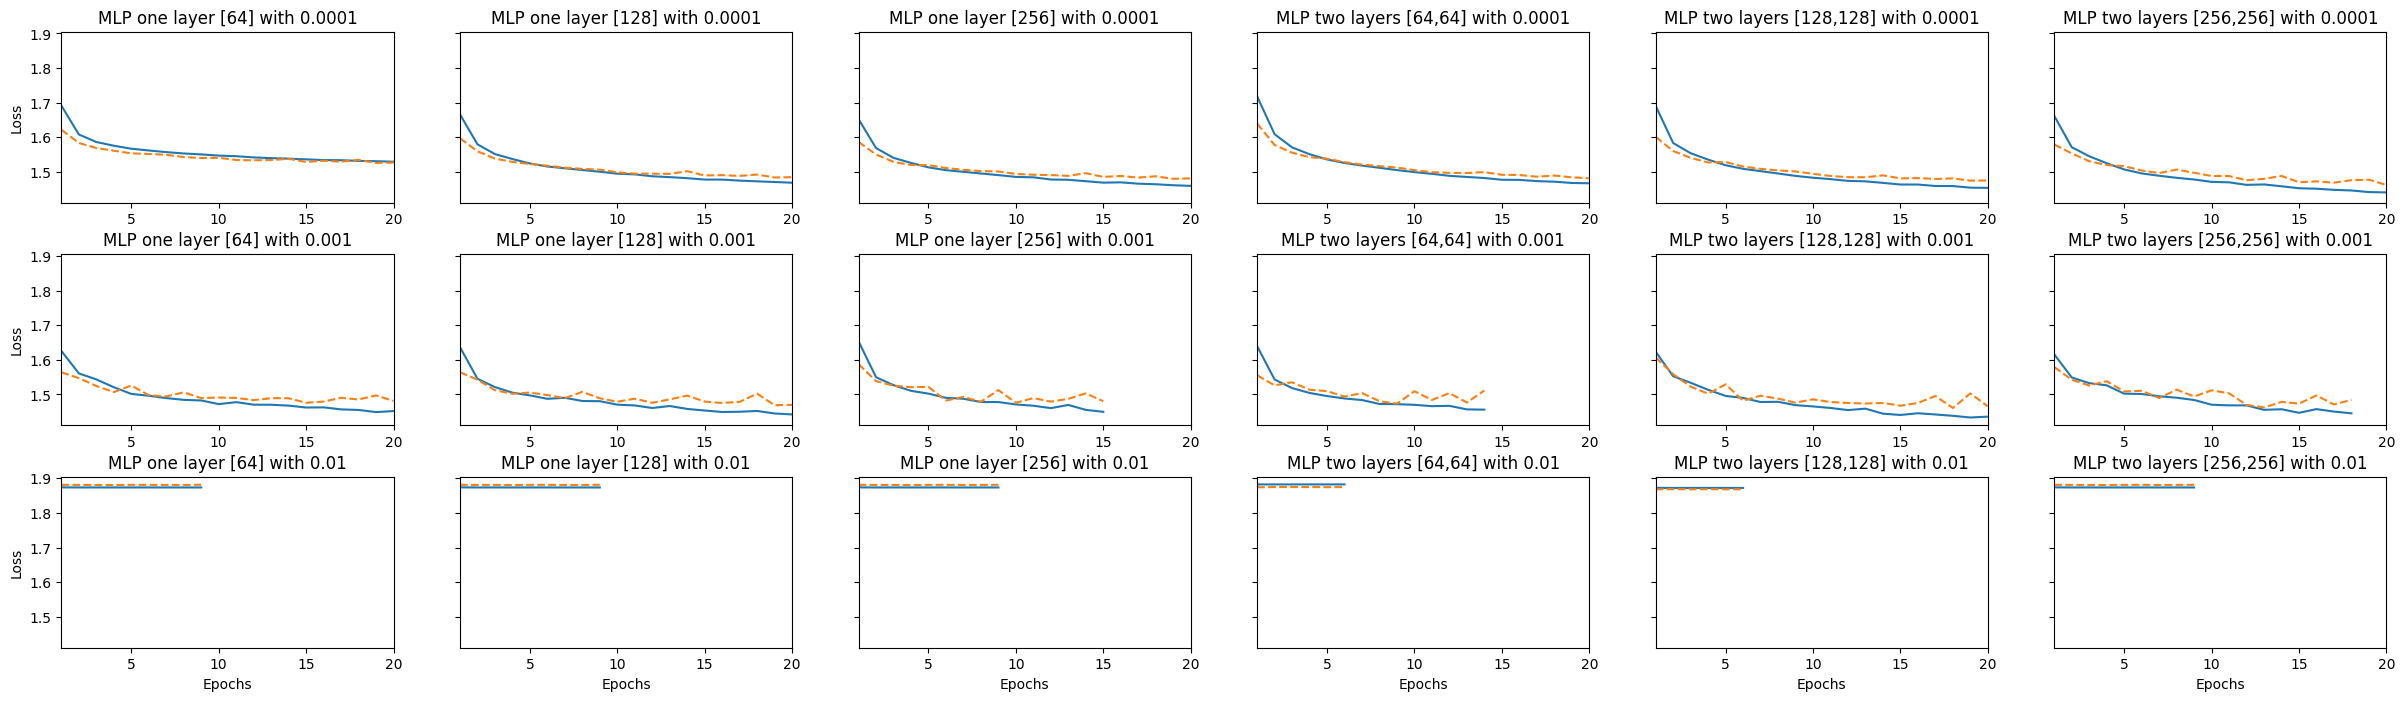

In [76]:
fig, axes = plt.subplots(3, 6, figsize=(30, 8), sharey=True, gridspec_kw={'hspace': 0.3})

## Plotting MLP train and val loss
# Learning rate = 0.0001
epochs = range(1, len(trainloss_1_64_0001) + 1)
axes[0][0].plot(epochs, trainloss_1_64_0001, label='Training loss')
axes[0][0].plot(epochs, valloss_1_64_0001, label='Validation loss', linestyle='dashed')
axes[0][0].set_title('MLP one layer [64] with 0.0001')
axes[0][0].set_ylabel('Loss')
axes[0][0].set_xticks([5, 10, 15, 20])
axes[0][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_128_0001) + 1)
axes[0][1].plot(epochs, trainloss_1_128_0001, label='Training loss')
axes[0][1].plot(epochs, valloss_1_128_0001, label='Validation loss', linestyle='dashed')
axes[0][1].set_title('MLP one layer [128] with 0.0001')
axes[0][1].set_xticks([5, 10, 15, 20])
axes[0][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_256_0001) + 1)
axes[0][2].plot(epochs, trainloss_1_256_0001, label='Training loss')
axes[0][2].plot(epochs, valloss_1_256_0001, label='Validation loss', linestyle='dashed')
axes[0][2].set_title('MLP one layer [256] with 0.0001')
axes[0][2].set_xticks([5, 10, 15, 20])
axes[0][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_64_0001) + 1)
axes[0][3].plot(epochs, trainloss_2_64_0001, label='Training loss')
axes[0][3].plot(epochs, valloss_2_64_0001, label='Validation loss', linestyle='dashed')
axes[0][3].set_title('MLP two layers [64,64] with 0.0001')
axes[0][3].set_xticks([5, 10, 15, 20])
axes[0][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_128_0001) + 1)
axes[0][4].plot(epochs, trainloss_2_128_0001, label='Training loss')
axes[0][4].plot(epochs, valloss_2_128_0001, label='Validation loss', linestyle='dashed')
axes[0][4].set_title('MLP two layers [128,128] with 0.0001')
axes[0][4].set_xticks([5, 10, 15, 20])
axes[0][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_256_0001) + 1)
axes[0][5].plot(epochs, trainloss_2_256_0001, label='Training loss')
axes[0][5].plot(epochs, valloss_2_256_0001, label='Validation loss', linestyle='dashed')
axes[0][5].set_title('MLP two layers [256,256] with 0.0001')
axes[0][5].set_xticks([5, 10, 15, 20])
axes[0][5].set_xlim(1, 20)

# Learning rate = 0.001
epochs = range(1, len(trainloss_1_64_001) + 1)
axes[1][0].plot(epochs, trainloss_1_64_001, label='Training loss')
axes[1][0].plot(epochs, valloss_1_64_001, label='Validation loss', linestyle='dashed')
axes[1][0].set_title('MLP one layer [64] with 0.001')
axes[1][0].set_ylabel('Loss')
axes[1][0].set_xticks([5, 10, 15, 20])
axes[1][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_128_001) + 1)
axes[1][1].plot(epochs, trainloss_1_128_001, label='Training loss')
axes[1][1].plot(epochs, valloss_1_128_001, label='Validation loss', linestyle='dashed')
axes[1][1].set_title('MLP one layer [128] with 0.001')
axes[1][1].set_xticks([5, 10, 15, 20])
axes[1][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_256_001) + 1)
axes[1][2].plot(epochs, trainloss_1_256_001, label='Training loss')
axes[1][2].plot(epochs, valloss_1_256_001, label='Validation loss', linestyle='dashed')
axes[1][2].set_title('MLP one layer [256] with 0.001')
axes[1][2].set_xticks([5, 10, 15, 20])
axes[1][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_64_001) + 1)
axes[1][3].plot(epochs, trainloss_2_64_001, label='Training loss')
axes[1][3].plot(epochs, valloss_2_64_001, label='Validation loss', linestyle='dashed')
axes[1][3].set_title('MLP two layers [64,64] with 0.001')
axes[1][3].set_xticks([5, 10, 15, 20])
axes[1][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_128_001) + 1)
axes[1][4].plot(epochs, trainloss_2_128_001, label='Training loss')
axes[1][4].plot(epochs, valloss_2_128_001, label='Validation loss', linestyle='dashed')
axes[1][4].set_title('MLP two layers [128,128] with 0.001')
axes[1][4].set_xticks([5, 10, 15, 20])
axes[1][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_256_001) + 1)
axes[1][5].plot(epochs, trainloss_2_256_001, label='Training loss')
axes[1][5].plot(epochs, valloss_2_256_001, label='Validation loss', linestyle='dashed')
axes[1][5].set_title('MLP two layers [256,256] with 0.001')
axes[1][5].set_xticks([5, 10, 15, 20])
axes[1][5].set_xlim(1, 20)

# Learning rate = 0.01
epochs = range(1, len(trainloss_1_64_01) + 1)
axes[2][0].plot(epochs, trainloss_1_64_01, label='Training loss')
axes[2][0].plot(epochs, valloss_1_64_01, label='Validation loss', linestyle='dashed')
axes[2][0].set_title('MLP one layer [64] with 0.01')
axes[2][0].set_ylabel('Loss')
axes[2][0].set_xticks([5, 10, 15, 20])
axes[2][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_128_01) + 1)
axes[2][1].plot(epochs, trainloss_1_128_01, label='Training loss')
axes[2][1].plot(epochs, valloss_1_128_01, label='Validation loss', linestyle='dashed')
axes[2][1].set_title('MLP one layer [128] with 0.01')
axes[2][1].set_xticks([5, 10, 15, 20])
axes[2][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_256_01) + 1)
axes[2][2].plot(epochs, trainloss_1_256_01, label='Training loss')
axes[2][2].plot(epochs, valloss_1_256_01, label='Validation loss', linestyle='dashed')
axes[2][2].set_title('MLP one layer [256] with 0.01')
axes[2][2].set_xticks([5, 10, 15, 20])
axes[2][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_64_01) + 1)
axes[2][3].plot(epochs, trainloss_2_64_01, label='Training loss')
axes[2][3].plot(epochs, valloss_2_64_01, label='Validation loss', linestyle='dashed')
axes[2][3].set_title('MLP two layers [64,64] with 0.01')
axes[2][3].set_xticks([5, 10, 15, 20])
axes[2][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_128_01) + 1)
axes[2][4].plot(epochs, trainloss_2_128_01, label='Training loss')
axes[2][4].plot(epochs, valloss_2_128_01, label='Validation loss', linestyle='dashed')
axes[2][4].set_title('MLP two layers [128,128] with 0.01')
axes[2][4].set_xticks([5, 10, 15, 20])
axes[2][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_2_256_01) + 1)
axes[2][5].plot(epochs, trainloss_2_256_01, label='Training loss')
axes[2][5].plot(epochs, valloss_2_256_01, label='Validation loss', linestyle='dashed')
axes[2][5].set_title('MLP two layers [256,256] with 0.01')
axes[2][5].set_xticks([5, 10, 15, 20])
axes[2][5].set_xlim(1, 20)

axes[2][0].set_xlabel('Epochs')
axes[2][1].set_xlabel('Epochs')
axes[2][2].set_xlabel('Epochs')
axes[2][3].set_xlabel('Epochs')
axes[2][4].set_xlabel('Epochs')
axes[2][5].set_xlabel('Epochs')
plt.show()

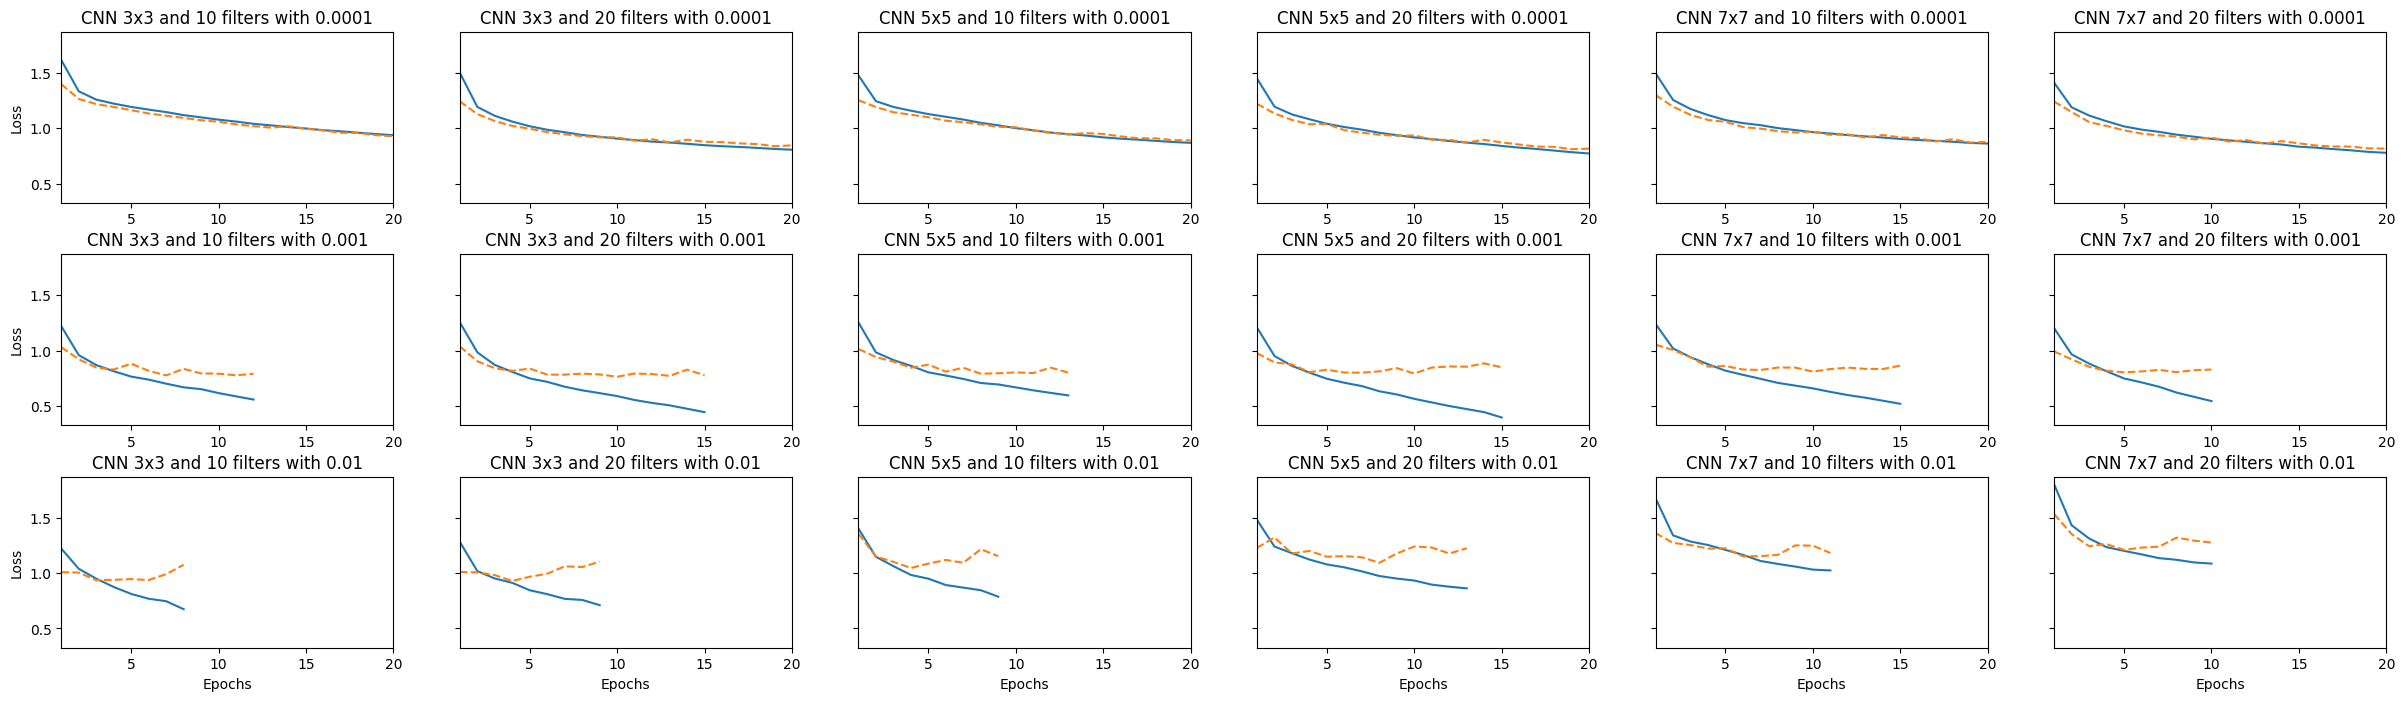

In [79]:
fig, axes = plt.subplots(3, 6, figsize=(30, 8), sharey=True, gridspec_kw={'hspace': 0.3})

## Plotting CNN train and val loss
# Learning rate = 0.0001
epochs = range(1, len(trainloss_3_10_0001) + 1)
axes[0][0].plot(epochs, trainloss_3_10_0001, label='Training loss')
axes[0][0].plot(epochs, valloss_3_10_0001, label='Validation loss', linestyle='dashed')
axes[0][0].set_title('CNN 3x3 and 10 filters with 0.0001')
axes[0][0].set_ylabel('Loss')
axes[0][0].set_xticks([5, 10, 15, 20])
axes[0][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_3_20_0001) + 1)
axes[0][1].plot(epochs, trainloss_3_20_0001, label='Training loss')
axes[0][1].plot(epochs, valloss_3_20_0001, label='Validation loss', linestyle='dashed')
axes[0][1].set_title('CNN 3x3 and 20 filters with 0.0001')
axes[0][1].set_xticks([5, 10, 15, 20])
axes[0][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_10_0001) + 1)
axes[0][2].plot(epochs, trainloss_5_10_0001, label='Training loss')
axes[0][2].plot(epochs, valloss_5_10_0001, label='Validation loss', linestyle='dashed')
axes[0][2].set_title('CNN 5x5 and 10 filters with 0.0001')
axes[0][2].set_xticks([5, 10, 15, 20])
axes[0][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_20_0001) + 1)
axes[0][3].plot(epochs, trainloss_5_20_0001, label='Training loss')
axes[0][3].plot(epochs, valloss_5_20_0001, label='Validation loss', linestyle='dashed')
axes[0][3].set_title('CNN 5x5 and 20 filters with 0.0001')
axes[0][3].set_xticks([5, 10, 15, 20])
axes[0][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_10_0001) + 1)
axes[0][4].plot(epochs, trainloss_7_10_0001, label='Training loss')
axes[0][4].plot(epochs, valloss_7_10_0001, label='Validation loss', linestyle='dashed')
axes[0][4].set_title('CNN 7x7 and 10 filters with 0.0001')
axes[0][4].set_xticks([5, 10, 15, 20])
axes[0][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_20_0001) + 1)
axes[0][5].plot(epochs, trainloss_7_20_0001, label='Training loss')
axes[0][5].plot(epochs, valloss_7_20_0001, label='Validation loss', linestyle='dashed')
axes[0][5].set_title('CNN 7x7 and 20 filters with 0.0001')
axes[0][5].set_xticks([5, 10, 15, 20])
axes[0][5].set_xlim(1, 20)

# Learning rate = 0.001
epochs = range(1, len(trainloss_3_10_001) + 1)
axes[1][0].plot(epochs, trainloss_3_10_001, label='Training loss')
axes[1][0].plot(epochs, valloss_3_10_001, label='Validation loss', linestyle='dashed')
axes[1][0].set_title('CNN 3x3 and 10 filters with 0.001')
axes[1][0].set_ylabel('Loss')
axes[1][0].set_xticks([5, 10, 15, 20])
axes[1][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_3_20_001) + 1)
axes[1][1].plot(epochs, trainloss_3_20_001, label='Training loss')
axes[1][1].plot(epochs, valloss_3_20_001, label='Validation loss', linestyle='dashed')
axes[1][1].set_title('CNN 3x3 and 20 filters with 0.001')
axes[1][1].set_xticks([5, 10, 15, 20])
axes[1][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_10_001) + 1)
axes[1][2].plot(epochs, trainloss_5_10_001, label='Training loss')
axes[1][2].plot(epochs, valloss_5_10_001, label='Validation loss', linestyle='dashed')
axes[1][2].set_title('CNN 5x5 and 10 filters with 0.001')
axes[1][2].set_xticks([5, 10, 15, 20])
axes[1][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_20_001) + 1)
axes[1][3].plot(epochs, trainloss_5_20_001, label='Training loss')
axes[1][3].plot(epochs, valloss_5_20_001, label='Validation loss', linestyle='dashed')
axes[1][3].set_title('CNN 5x5 and 20 filters with 0.001')
axes[1][3].set_xticks([5, 10, 15, 20])
axes[1][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_10_001) + 1)
axes[1][4].plot(epochs, trainloss_7_10_001, label='Training loss')
axes[1][4].plot(epochs, valloss_7_10_001, label='Validation loss', linestyle='dashed')
axes[1][4].set_title('CNN 7x7 and 10 filters with 0.001')
axes[1][4].set_xticks([5, 10, 15, 20])
axes[1][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_20_001) + 1)
axes[1][5].plot(epochs, trainloss_7_20_001, label='Training loss')
axes[1][5].plot(epochs, valloss_7_20_001, label='Validation loss', linestyle='dashed')
axes[1][5].set_title('CNN 7x7 and 20 filters with 0.001')
axes[1][5].set_xticks([5, 10, 15, 20])
axes[1][5].set_xlim(1, 20)

# Learning rate = 0.01
epochs = range(1, len(trainloss_3_10_01) + 1)
axes[2][0].plot(epochs, trainloss_3_10_01, label='Training loss')
axes[2][0].plot(epochs, valloss_3_10_01, label='Validation loss', linestyle='dashed')
axes[2][0].set_title('CNN 3x3 and 10 filters with 0.01')
axes[2][0].set_ylabel('Loss')
axes[2][0].set_xticks([5, 10, 15, 20])
axes[2][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_3_20_01) + 1)
axes[2][1].plot(epochs, trainloss_3_20_01, label='Training loss')
axes[2][1].plot(epochs, valloss_3_20_01, label='Validation loss', linestyle='dashed')
axes[2][1].set_title('CNN 3x3 and 20 filters with 0.01')
axes[2][1].set_xticks([5, 10, 15, 20])
axes[2][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_10_01) + 1)
axes[2][2].plot(epochs, trainloss_5_10_01, label='Training loss')
axes[2][2].plot(epochs, valloss_5_10_01, label='Validation loss', linestyle='dashed')
axes[2][2].set_title('CNN 5x5 and 10 filters with 0.01')
axes[2][2].set_xticks([5, 10, 15, 20])
axes[2][2].set_xlim(1, 20)

epochs = range(1, len(trainloss_5_20_01) + 1)
axes[2][3].plot(epochs, trainloss_5_20_01, label='Training loss')
axes[2][3].plot(epochs, valloss_5_20_01, label='Validation loss', linestyle='dashed')
axes[2][3].set_title('CNN 5x5 and 20 filters with 0.01')
axes[2][3].set_xticks([5, 10, 15, 20])
axes[2][3].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_10_01) + 1)
axes[2][4].plot(epochs, trainloss_7_10_01, label='Training loss')
axes[2][4].plot(epochs, valloss_7_10_01, label='Validation loss', linestyle='dashed')
axes[2][4].set_title('CNN 7x7 and 10 filters with 0.01')
axes[2][4].set_xticks([5, 10, 15, 20])
axes[2][4].set_xlim(1, 20)

epochs = range(1, len(trainloss_7_20_01) + 1)
axes[2][5].plot(epochs, trainloss_7_20_01, label='Training loss')
axes[2][5].plot(epochs, valloss_7_20_01, label='Validation loss', linestyle='dashed')
axes[2][5].set_title('CNN 7x7 and 20 filters with 0.01')
axes[2][5].set_xticks([5, 10, 15, 20])
axes[2][5].set_xlim(1, 20)

axes[2][0].set_xlabel('Epochs')
axes[2][1].set_xlabel('Epochs')
axes[2][2].set_xlabel('Epochs')
axes[2][3].set_xlabel('Epochs')
axes[2][4].set_xlabel('Epochs')
axes[2][5].set_xlabel('Epochs')
plt.show()

### Supplementary materials

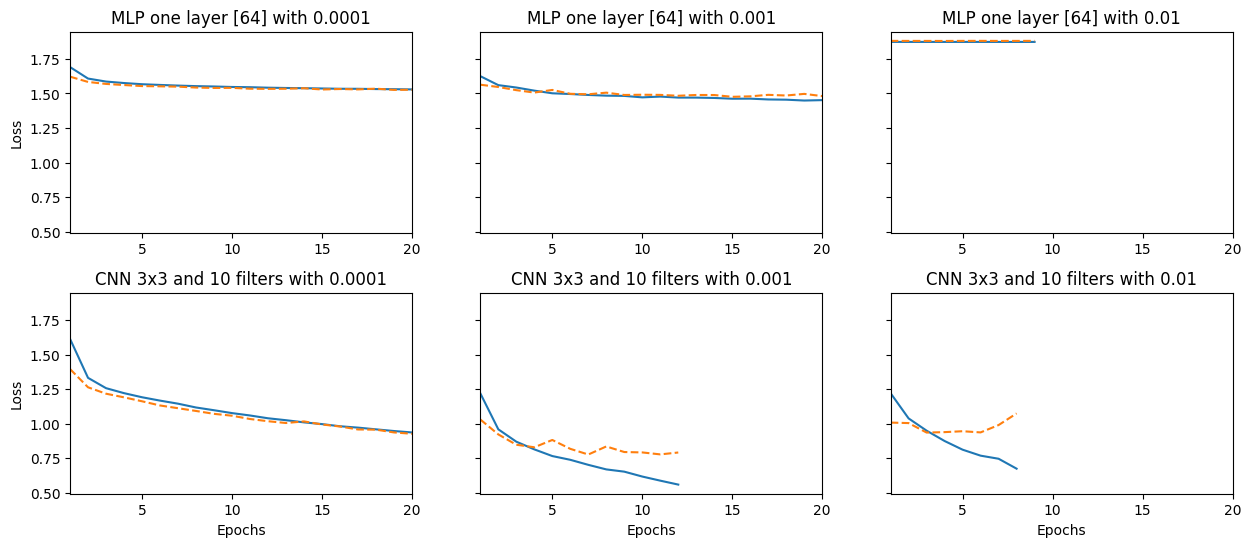

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharey=True, gridspec_kw={'hspace': 0.3})

# MLPs in [64] with different learning rates
epochs = range(1, len(trainloss_1_64_0001) + 1)
axes[0][0].plot(epochs, trainloss_1_64_0001, label='Training loss')
axes[0][0].plot(epochs, valloss_1_64_0001, label='Validation loss', linestyle='dashed')
axes[0][0].set_title('MLP one layer [64] with 0.0001')
axes[0][0].set_ylabel('Loss')
axes[0][0].set_xticks([5, 10, 15, 20])
axes[0][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_64_001) + 1)
axes[0][1].plot(epochs, trainloss_1_64_001, label='Training loss')
axes[0][1].plot(epochs, valloss_1_64_001, label='Validation loss', linestyle='dashed')
axes[0][1].set_title('MLP one layer [64] with 0.001')
axes[0][1].set_xticks([5, 10, 15, 20])
axes[0][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_1_64_01) + 1)
axes[0][2].plot(epochs, trainloss_1_64_01, label='Training loss')
axes[0][2].plot(epochs, valloss_1_64_01, label='Validation loss', linestyle='dashed')
axes[0][2].set_title('MLP one layer [64] with 0.01')
axes[0][2].set_xticks([5, 10, 15, 20])
axes[0][2].set_xlim(1, 20)

# CNNs in 3x3 and 10 filters with different learning rates
epochs = range(1, len(trainloss_3_10_0001) + 1)
axes[1][0].plot(epochs, trainloss_3_10_0001, label='Training loss')
axes[1][0].plot(epochs, valloss_3_10_0001, label='Validation loss', linestyle='dashed')
axes[1][0].set_title('CNN 3x3 and 10 filters with 0.0001')
axes[1][0].set_ylabel('Loss')
axes[1][0].set_xticks([5, 10, 15, 20])
axes[1][0].set_xlim(1, 20)

epochs = range(1, len(trainloss_3_10_001) + 1)
axes[1][1].plot(epochs, trainloss_3_10_001, label='Training loss')
axes[1][1].plot(epochs, valloss_3_10_001, label='Validation loss', linestyle='dashed')
axes[1][1].set_title('CNN 3x3 and 10 filters with 0.001')
axes[1][1].set_xticks([5, 10, 15, 20])
axes[1][1].set_xlim(1, 20)

epochs = range(1, len(trainloss_3_10_01) + 1)
axes[1][2].plot(epochs, trainloss_3_10_01, label='Training loss')
axes[1][2].plot(epochs, valloss_3_10_01, label='Validation loss', linestyle='dashed')
axes[1][2].set_title('CNN 3x3 and 10 filters with 0.01')
axes[1][2].set_xticks([5, 10, 15, 20])
axes[1][2].set_xlim(1, 20)

axes[1][0].set_xlabel('Epochs')
axes[1][1].set_xlabel('Epochs')
axes[1][2].set_xlabel('Epochs')

plt.show()

The libraries version that used in this coding.

In [95]:
import sys
import torchvision
import matplotlib
import sklearn

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)

Python version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:35:25) [Clang 16.0.6 ]
PyTorch version: 2.1.2.post2
Torchvision version: 0.16.1
Matplotlib version: 3.8.3
Scikit-learn version: 1.4.1.post1
